In [1]:
library(data.table)
library(dplyr)
# data about projects from DEVPOST
df0 = fread('/da4_data/play/trackhack/Analysis/CodeUsage/RQ3a.csv')
df0 = df0 %>% select(1,2,4,9,23)
str(df0)
# Number of blobs created before, during, after
df1 = fread('/da4_data/play/trackhack/Analysis/CodeGeneration/Analysis_TF_Pivot.csv')
str(df1)
# composition of the project
df11 = fread('/da4_data/play/trackhack/Analysis/CodeUsage/pivotCodeInfoGroup.csv')
str(df11)


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




Classes 'data.table' and 'data.frame':	16063 obs. of  5 variables:
 $ projectID_x           : chr  "shreyakate_SheTechs" "Madalosso_vanhackathon-mastermind" "mdnahian_taylor" "gchamp20_AndYetItCompiles" ...
 $ number-of-technologies: int  6 2 11 40 2 7 7 3 9 4 ...
 $ number-of-participants: int  5 1 4 3 3 4 2 1 4 2 ...
 $ hackathon-is-colocated: logi  TRUE FALSE TRUE TRUE TRUE TRUE ...
 $ Ratio                 : num  0.0833 0 1 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
Classes 'data.table' and 'data.frame':	17424 obs. of  4 variables:
 $ ProjectID: chr  "0-Solver-0_CiscoSparkUnityInteraction" "00Bren00_ProfHacks2018NonceSolver" "0807Jpatel_Hack-Bot" "09wakharet_Protest-Smart" ...
 $ Before   : int  14 0 1375 6 2 0 10 2 14 4 ...
 $ During   : int  0 5 66 40 0 11 0 11 5 2 ...
 $ After    : int  1 0 0 0 0 0 0 8 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 
Classes 'data.table' and 'data.frame':	22086 obs. of  6 variables:
 $ ProjectID: chr  "0-Solver-0_CiscoSparkUnit

In [2]:
# merging the datasets
df = merge(merge(df0, df1, by.x='projectID_x', by.y='ProjectID'), df11, by.x='projectID_x', by.y='ProjectID')
str(df)

Classes 'data.table' and 'data.frame':	16063 obs. of  13 variables:
 $ projectID_x           : chr  "00Bren00_ProfHacks2018NonceSolver" "0807Jpatel_Hack-Bot" "09wakharet_Protest-Smart" "0lumide_BoilerMake14" ...
 $ number-of-technologies: int  2 9 4 2 4 6 6 2 5 3 ...
 $ number-of-participants: int  3 1 4 1 1 3 2 2 4 2 ...
 $ hackathon-is-colocated: logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ Ratio                 : num  1 0 0 0 0 1 0 0 1 1 ...
 $ Before                : int  0 1375 6 0 2 14 4 41 98 1 ...
 $ During                : int  5 66 40 11 11 5 2 57 138 1 ...
 $ After                 : int  0 0 0 0 8 0 0 0 0 0 ...
 $ pctOther              : num  0.0714 0.0896 0.2041 0.6917 0.1875 ...
 $ pctData               : num  0.357 0.354 0.051 0.183 0.484 ...
 $ pctMarkup             : num  0 0.057 0.224 0 0 ...
 $ pctCode               : num  0.3571 0.3948 0.4694 0.0917 0.3281 ...
 $ pctProse              : num  0.2143 0.1047 0.051 0.0333 0 ...
 - attr(*, ".internal.selfref")=<externalptr>

In [5]:
# preprocessing
df2 = df
df2$projectID_x = NULL
colnames(df2)[c(1,2,3)] = c('no.Technology', 'no.Participant','is.colocated')

dff = df2[complete.cases(df2),]

dfi = dff
dfi$Y = (ifelse(dfi$Ratio >0, TRUE, FALSE))
dfi$Ratio = NULL

dfi$pctOther = NULL # prevent sum of 100%
dfi$After = NULL # prevent data leakage
dfi = dfi[ dfi$no.Technology>0 ,] # subsetting projects
str(dfi)

Classes 'data.table' and 'data.frame':	12881 obs. of  10 variables:
 $ no.Technology : int  2 4 6 6 2 5 3 7 1 1 ...
 $ no.Participant: int  3 4 3 2 2 4 2 2 2 4 ...
 $ is.colocated  : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ Before        : int  0 6 14 4 41 98 1 0 252 13 ...
 $ During        : int  5 40 5 2 57 138 1 8 92 13 ...
 $ pctData       : num  0.357 0.051 0.325 0.198 0.162 ...
 $ pctMarkup     : num  0 0.2245 0.0355 0.0549 0.0154 ...
 $ pctCode       : num  0.3571 0.4694 0.1124 0.0659 0.7538 ...
 $ pctProse      : num  0.2143 0.051 0.0296 0.0549 0.0615 ...
 $ Y             : logi  TRUE FALSE TRUE FALSE FALSE TRUE ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [6]:
# using GAM modeling
library(mgcv)
dfi$is.colocated = factor(dfi$is.colocated )
gam1 = mgcv::gam(Y~ no.Participant+is.colocated+no.Technology+ Before+ During +
                    s(pctProse) + s(pctData)+ s(pctCode)+ s(pctMarkup)  , 
           data = dfi, family=binomial, method='REML')
summary(gam1)

Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.




Family: binomial 
Link function: logit 

Formula:
Y ~ no.Participant + is.colocated + no.Technology + Before + 
    During + s(pctProse) + s(pctData) + s(pctCode) + s(pctMarkup)

Parametric coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.483e+00  1.182e-01 -12.545  < 2e-16 ***
no.Participant         2.040e-01  1.806e-02  11.296  < 2e-16 ***
is.colocatedTRUE       2.448e-01  1.018e-01   2.404   0.0162 *  
no.Technology          2.577e-02  5.939e-03   4.340 1.43e-05 ***
Before                 1.252e-04  1.744e-05   7.176 7.17e-13 ***
During                 2.782e-03  3.977e-04   6.996 2.64e-12 ***
LicenseTypeOSSLICENSE  1.248e-01  5.219e-02   2.392   0.0168 *  
LicenseTypeOther      -6.520e-02  6.657e-02  -0.980   0.3273    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
               edf Ref.df Chi.sq  p-value    
s(pctProse)  3.698  4.613 10.805   0.0438 *  
s(pctData)   

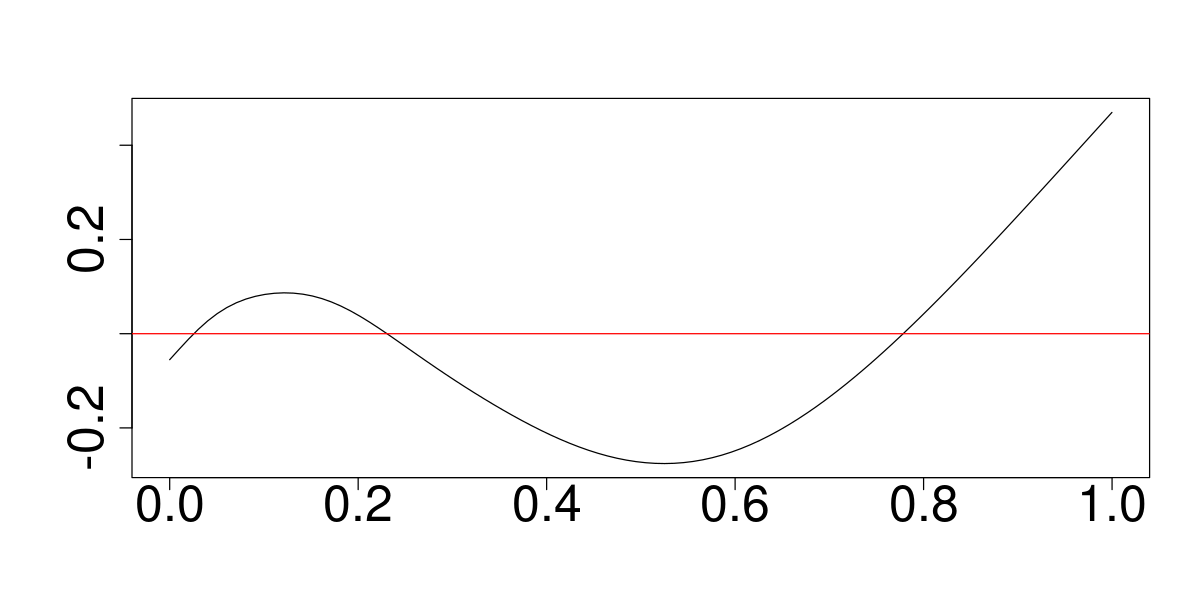

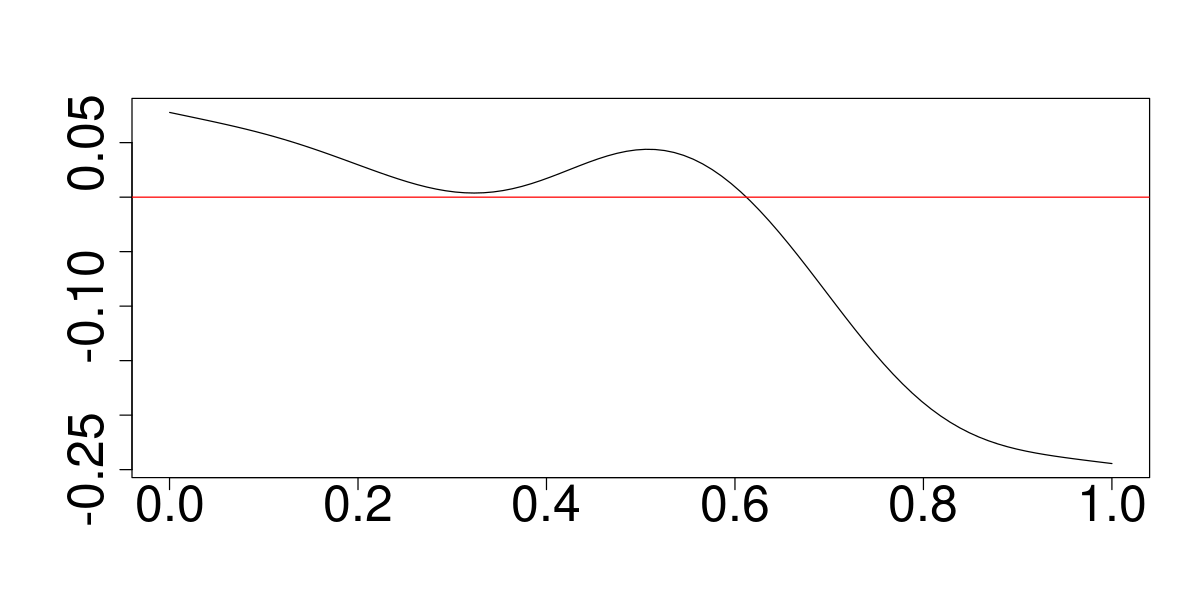

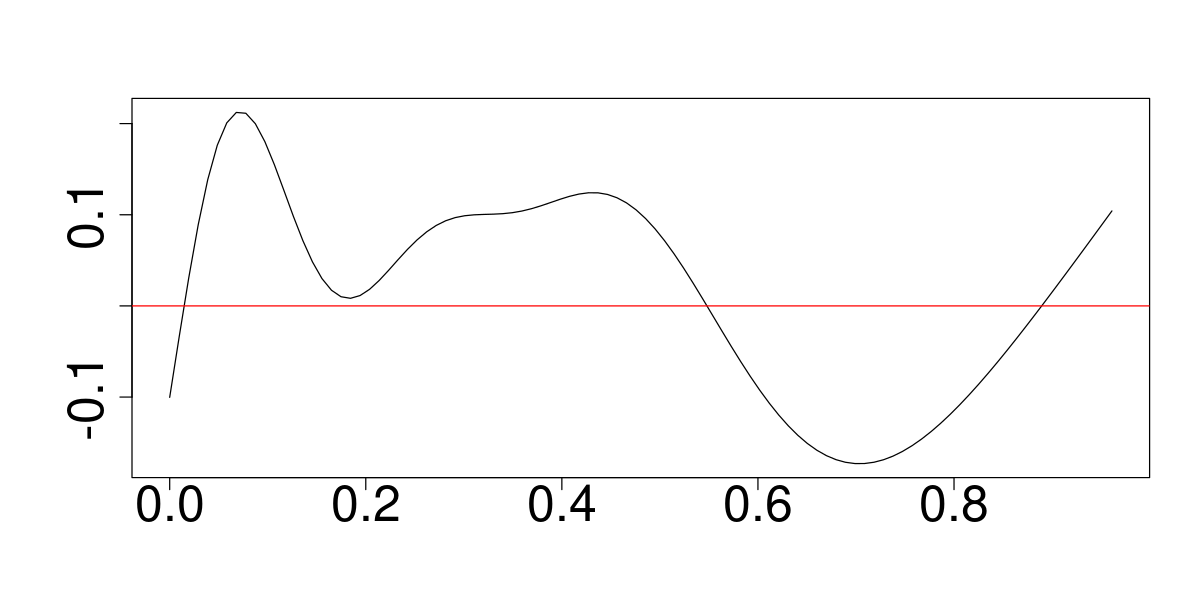

In [7]:
# Plot variable effect
options(repr.plot.width = 10, repr.plot.height = 5)

par(mar = c(5.1, 5.5, 4.1, 2.1))
plot(gam1, scale = 0, select =1, se=F, ylab = '', xlab = '', cex.axis = 2.5, cex.lab=2.5, shade=T) 
abline(h=0, lty = 1, col = 'red')
plot(gam1, scale = 0, select =3, se=F, ylab = '', xlab = '', cex.axis = 2.5, cex.lab=2.5, shade=T) 
abline(h=0, lty = 1, col = 'red')
plot(gam1, scale = 0, select =4, se=F, ylab = '', xlab = '', cex.axis = 2.5, cex.lab=2.5, shade=T) 
abline(h=0, lty = 1, col = 'red')